Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


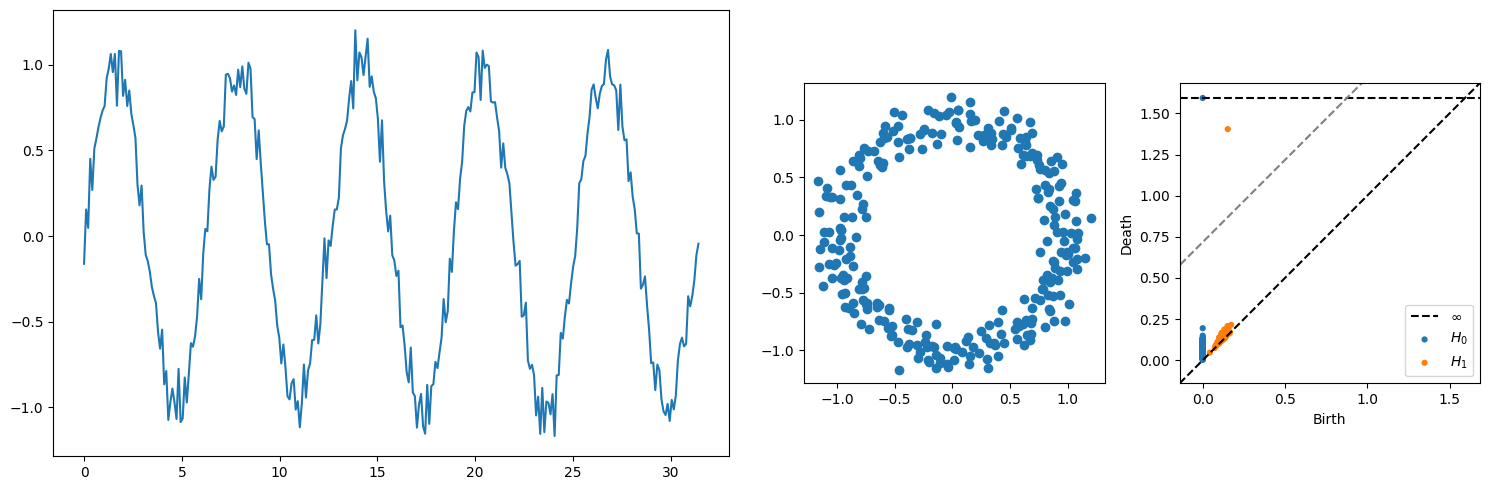

In [30]:
import numpy as np
import recycle as re
import matplotlib.pyplot as plt
from ripser import Rips
from persim import plot_diagrams
from scipy.linalg import svdvals

x = np.linspace(0, 10 * np.pi, 300)
fx = np.sin(x) + np.random.normal(0, 0.1, size=(x.shape))

freqs, coefs, peaks = re.timeseries.find_frequency_peaks(
    fx, x, min_height=0.1, distance=1
)


# delays
rate = 10 * np.pi / 300
delays = np.linspace(0, 45 * rate, 100)
average_orth = [re.timeseries.gamma_value(tau, freqs[peaks]) for tau in delays]
min_delay = delays[np.argmin(average_orth)]
delay = int(min_delay // rate)


vandermond = re.timeseries.omega_matrix(min_delay, freqs[peaks])
sigma = svdvals(vandermond)
f_approx = re.timeseries.reconstruct_signal(coefs, peaks)
diff = np.abs(fx - f_approx)
lower_bound = np.sqrt(3) * np.max(np.abs(coefs[peaks])) * np.min(sigma) - np.sqrt(
    np.sum(peaks) + 1
) * np.max(diff)

# embedding
embedding = re.timeseries.time_delay_embedding(fx, dimension=np.sum(peaks), delay=delay)


### TDA STUFF

mosaic = "AABC"
fig, ax = plt.subplot_mosaic(mosaic,figsize=(15,5))
ax["A"].plot(x, fx)
ax["B"].scatter(embedding[:, 0], embedding[:, 1])
ax["B"].axis("square")

rips = Rips()
diags = rips.fit_transform(embedding)
plot_diagrams(diags, ax=ax["C"])
b_values = np.linspace(-10, 5, 15)
# Calculate y values for the line at a distance of 0.2 from the line x=y
d_values = b_values + lower_bound
# Plot the line x=y for reference
ax["C"].plot(b_values, d_values, linestyle="--", color="gray", label="x=y")
plt.tight_layout()
plt.show()



In [31]:
# GET THE INITIAL REPRESENTATIVE

# get all cycles bigger than the given bound
persistence = diags[1][:, 1] - diags[1][:, 0]
cycles = np.argwhere(persistence > lower_bound).flatten()
birth, death = diags[1][cycles[0]]


dimension = 2
points = embedding
max_edge_length = death * 1.01  # give a bit of slack
min_persistence = lower_bound
#min_persistence = 0.4


gudhi_complex = re.core.create_simplicial_complex(points, max_edge_length, dimension)
(
    representative,
    boundary_map,
    reduced_boundary_base,
) = re.core.get_representative_and_complex(gudhi_complex, dimension)
order_function = lambda s: (gudhi_complex.filtration(s), s)
# ISOLATED
np1_simplices = sorted(
    {
        simplex
        for simplex in reduced_boundary_base
        if gudhi_complex.filtration(simplex) <= death - min_persistence
    },
    key=order_function,
)
n_simplices = sorted(
    {
        tuple(sorted(simplex))
        for simplex, radius in gudhi_complex.get_filtration()
        if len(simplex) == dimension and radius <= death - min_persistence
    },
    key=order_function,
)
nm1_simplices = sorted(
    {
        tuple(sorted(simplex))
        for simplex, radius in gudhi_complex.get_filtration()
        if len(simplex) == dimension - 1 and radius <= death - min_persistence
    },
    key=order_function,
)

x_orig = re.core.lift_representative(representative, nm1_simplices, n_simplices)
boundary_matrix = re.core.build_boundary_matrix(n_simplices, np1_simplices)

In [32]:

def optimize_cycle(W, x_orig, boundary_matrix, n_simplices):
    # Run optimization
    x_min, status, objective_value = re.core.find_minimal_homologous_cycle(
        boundary_matrix, x_orig, W, use_gurobi=True
    )
    print("Objective value (L1 norm of x):", objective_value)
    min_cycle = set(
        [n_simplices[index] for index in np.argwhere(~np.isclose(x_min, 0)).flatten()]
    )  # be carefull here with values close to zero, add a tolerance parameter
    return min_cycle

def plot_cycle(min_cycle,label):
    fig, ax = plt.subplot_mosaic("AABBB",figsize=(15,5))
    for edge in representative:
        ax["A"].plot(*zip(points[edge[0]], points[edge[1]]), "--", color="k", alpha=0.5)
    for edge in min_cycle:
        ax["A"].plot(*zip(points[edge[0]], points[edge[1]]), "-", color="#FF0059", alpha=0.7)
    ax["A"].plot([], [], "--", color="k", alpha=0.5, label="Initial Representative")
    ax["A"].plot([], [], "-", color="#FF0059", label=label)
    ax["A"].plot(*zip(*points), "o")
    ax["A"].legend()
    ax["A"].axis("equal")
    ax["A"].spines[["right", "top"]].set_visible(False)
    
    vertex_set = {item for tup in min_cycle for item in tup}
    ax["B"].plot(x, fx)
    for vertex in vertex_set:
        ax["B"].axvline(x[vertex], color="k", alpha=0.1)
    plt.suptitle(label)
    plt.show()

## First set
**Objective**: Minimizing difference of adjacent time labels

**Time label Norm:**
1. Mean
2. Max
3. Sum

In [33]:

def time_adjacency_matrix(norm=np.mean):
    def inner_time_adjacency_matrix(simplex_j, simplex_i):
        if are_simplices_adjacent(simplex_j, simplex_i):
            return time_weight(simplex_i, simplex_j,norm=norm)
        else:
            return 0

    return inner_time_adjacency_matrix


def time_label(simplex_i,norm):
    return norm(simplex_i)

def time_weight(simp1, simp2,norm) -> float:
    return np.abs(time_label(simp1,norm=norm) - time_label(simp2,norm=norm))


def are_simplices_adjacent(simplex1, simplex2):
    # Count common elements between the two tuples
    common_elements = set(simplex1).intersection(set(simplex2))
    # Two simplices are adjacent if they share exactly n-1 elements
    if len(common_elements) == len(simplex1) - 1:
        return 1
    return 0


W_mean = re.core.create_weight_matrix(n_simplices, time_adjacency_matrix(np.mean))
mean_cycle = optimize_cycle(W_mean, x_orig, boundary_matrix, n_simplices)
W_sum = re.core.create_weight_matrix(n_simplices, time_adjacency_matrix(np.sum))
sum_cycle = optimize_cycle(W_sum, x_orig, boundary_matrix, n_simplices)
W_max = re.core.create_weight_matrix(n_simplices, time_adjacency_matrix(np.max))
max_cycle = optimize_cycle(W_max, x_orig, boundary_matrix, n_simplices)
W_min = re.core.create_weight_matrix(n_simplices, time_adjacency_matrix(np.min))
min_cycle = optimize_cycle(W_min, x_orig, boundary_matrix, n_simplices)

Set parameter Username
Set parameter LogFile to value "gurobi.log"
Using license file /Users/antonio/gurobi.lic
Academic license - for non-commercial use only - expires 2025-10-30

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A348)
Copyright (c) 2024, Gurobi Optimization, LLC

Read LP format model from file /var/folders/n0/wk41mth910n6jkj_vdp1m4z00000gn/T/b297715ad2ee44d6a84ee1d6b032b952-pulp.lp
Reading time = 0.02 seconds
OBJ: 8851 rows, 26268 columns, 43400 nonzeros

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8851 rows, 26268 columns and 43400 nonzeros
Model fingerprint: 0x9fd22da8
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+03, 9e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 1e+00]
Presolve removed 7647 rows and 7647 columns
Presolve time: 0.03s
Presolved: 1204 rows, 18621 columns, 40556 nonzeros

Concurrent LP opt

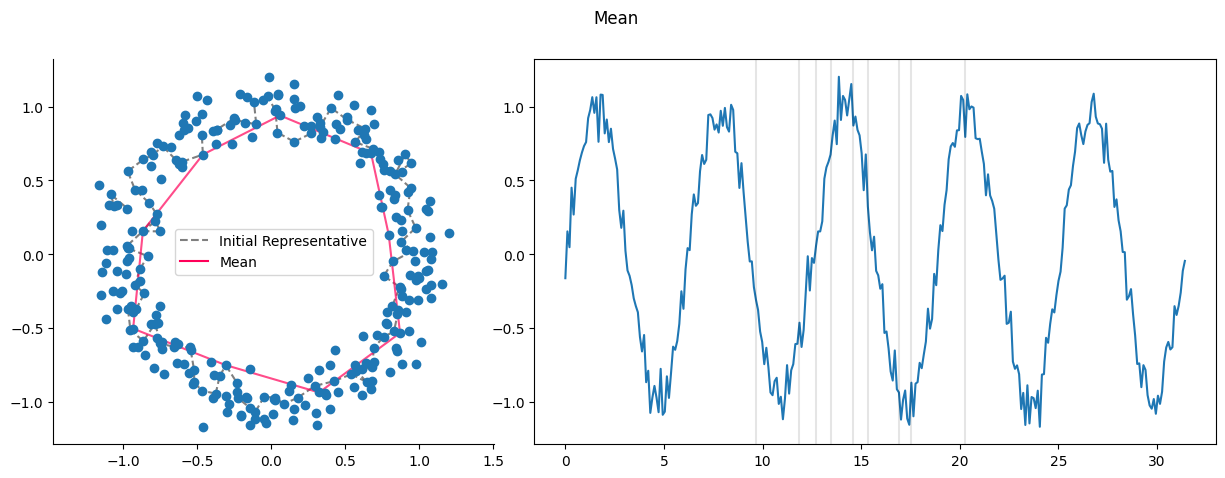

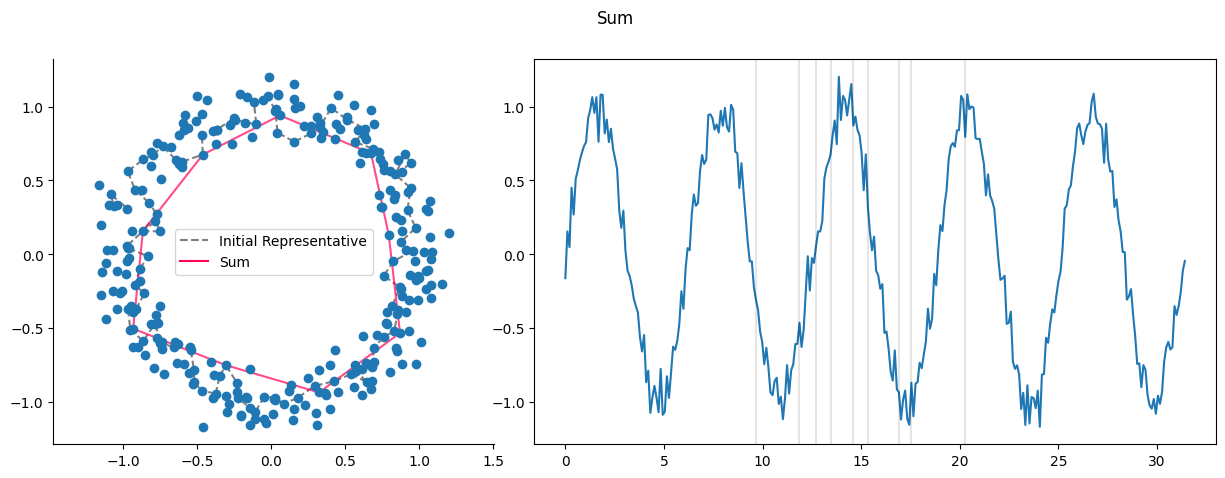

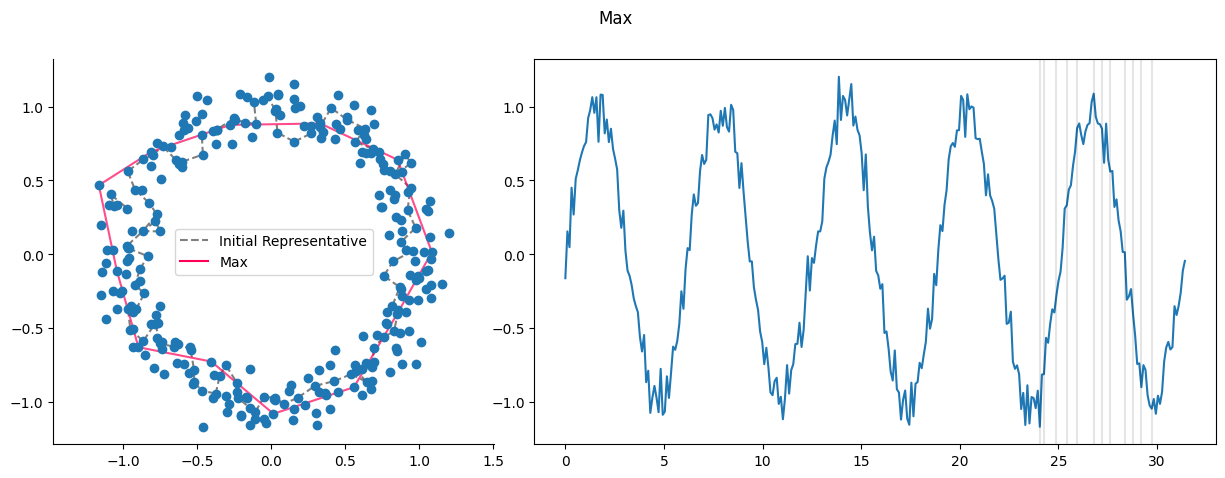

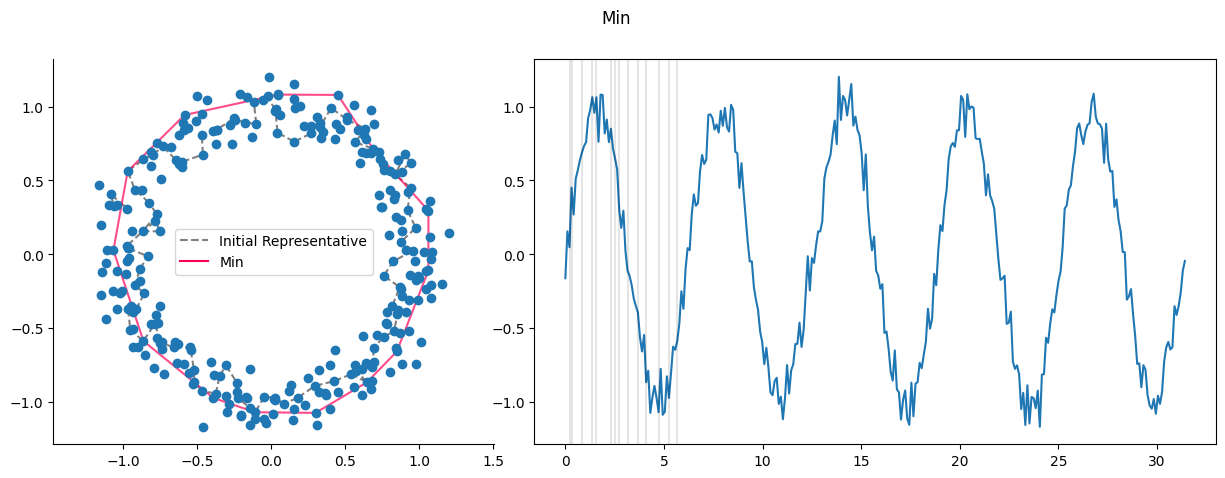

In [37]:
plot_cycle(mean_cycle,"Mean")
plot_cycle(sum_cycle,"Sum")
plot_cycle(max_cycle,"Max")
plot_cycle(min_cycle,"Min")

## Second set:
**Objective**: Minimize sum of label dispersion of each selected simplex

**Dispersions**:
1. Difference
2. Variance

In [36]:
def local_time_difference(
    inv_row_map,
) -> np.ndarray:
    n = len(inv_row_map)
    weight_matrix = np.zeros((n, n))

    for i in range(n):
      simplex_i = inv_row_map[i]
      weight_matrix[i,i] = np.abs(simplex_i[0]-simplex_i[1])
    return weight_matrix

def local_time_variance(
    inv_row_map,
) -> np.ndarray:
    n = len(inv_row_map)
    weight_matrix = np.zeros((n, n))

    for i in range(n):
      simplex_i = inv_row_map[i]
      weight_matrix[i,i] = np.var(simplex_i)
    return weight_matrix

def absolute_time_difference(
    inv_row_map,
) -> np.ndarray:
    n = len(inv_row_map)
    weight_matrix = np.zeros((n, n))

    for i in range(n):
        simplex_i = inv_row_map[i]
        for j in range(n):
            simplex_j = inv_row_map[j]
            union_set = set(simplex_i).union(simplex_j)
            sorted_union = sorted(union_set)
            weight_matrix[i,j] = np.abs(sorted_union[0]-sorted_union[-1])
    return weight_matrix


W_local = local_time_difference(n_simplices)
local_cycle = optimize_cycle(W_local, x_orig, boundary_matrix, n_simplices)

W_global = absolute_time_difference(n_simplices)
global_cycle = optimize_cycle(W_global, x_orig, boundary_matrix, n_simplices)

W_var = local_time_variance(n_simplices)
var_cycle = optimize_cycle(W_var, x_orig, boundary_matrix, n_simplices)

Set parameter Username
Set parameter LogFile to value "gurobi.log"
Using license file /Users/antonio/gurobi.lic
Academic license - for non-commercial use only - expires 2025-10-30

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.0.0 24A348)
Copyright (c) 2024, Gurobi Optimization, LLC

Read LP format model from file /var/folders/n0/wk41mth910n6jkj_vdp1m4z00000gn/T/ef36c63d530949639cdf832de2dd3fdf-pulp.lp
Reading time = 0.02 seconds
OBJ: 8851 rows, 26268 columns, 43400 nonzeros

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8851 rows, 26268 columns and 43400 nonzeros
Model fingerprint: 0xeed50a63
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-03, 1e+00]
Presolve removed 7647 rows and 7647 columns
Presolve time: 0.03s
Presolved: 1204 rows, 18621 columns, 40556 nonzeros

Concurrent LP opt

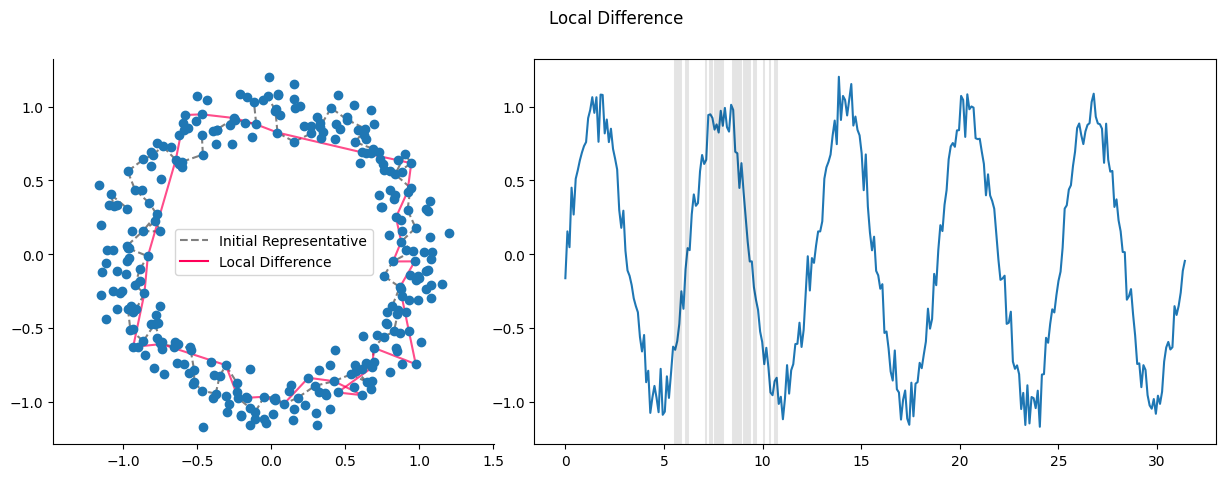

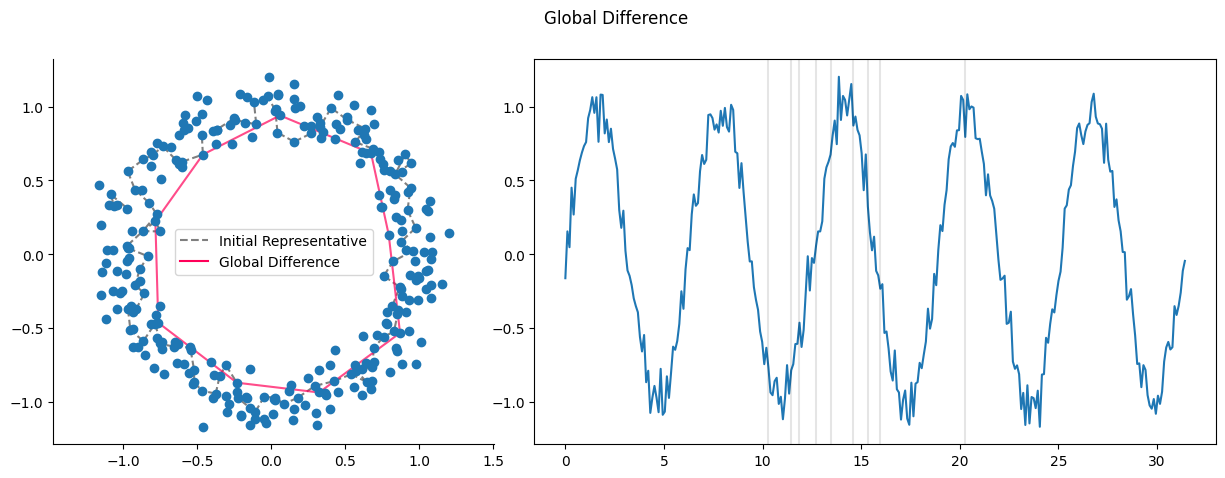

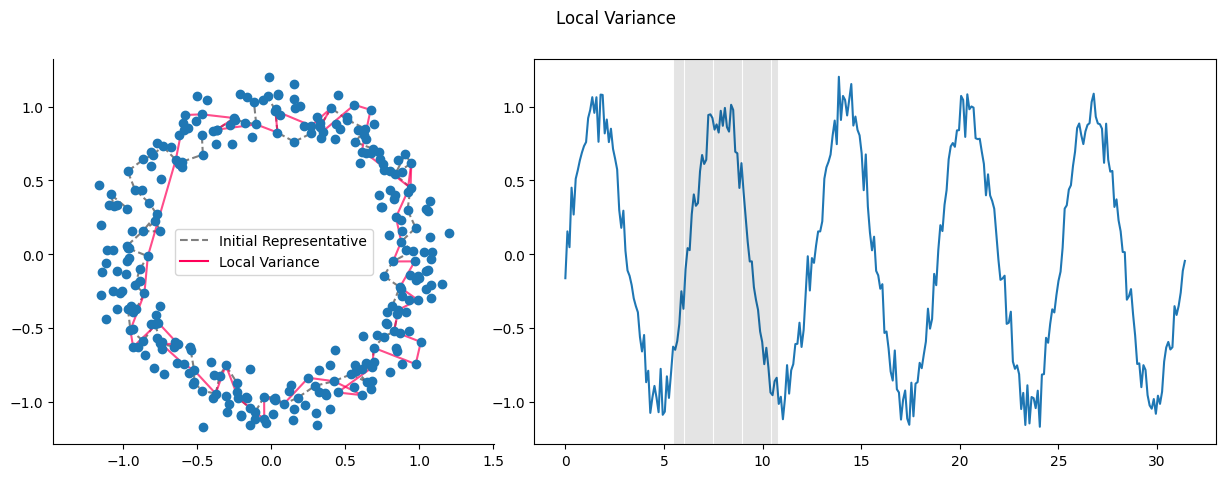

In [38]:
plot_cycle(local_cycle,"Local Difference")
plot_cycle(global_cycle,"Global Difference")
plot_cycle(var_cycle,"Local Variance")